### Table of contents

1. [Introduction](#1.-Introduction)
2. [Getting Set Up](#2.-Getting-Set-Up)
3. [Hello World: Making your first client-side API request](#3.-Hello-World:-Making-your-first-client-side-API-request)
4. [Example use cases](#example_use_cases) <br/>
    4.1 [POST a *Viewed Product* event](#4.1-POST-a-Viewed-Product-event) <br/>
    4.2 [Implementing customer product review events](#4.2-Implementing-customer-review-events) <br/>
    4.3 [Adding subscriber to a list](#4.3-Add-a-new-subscriber-to-a-list) <br/>
    4.4 [Create/Edit customer profile](#4.4-Implementing-a-sign-up-page) <br/>
5. [Common errors](#5.-Common-issues-for-developers)
6. [Wrapping up](#6.-Wrapping-up)


### FAQs

- [Who is this guide meant for?](#faq_who_meant_for)
- [What's a client-side request?](#faq_client_side_requests)
- [What do I need to follow along?](#faq_prereq)
- [What's an SDK?](#faq_sdk_info)
- [Where can I find Klaviyo's SDKs?](#faq_sdk_info)
- [Why is this guide in Python and not JavaScript?](#faq_why_not_js)
- [Where can I find examples of custom integrations using JavaScript?](#faq_why_not_js)
- [Why might some metrics appear twice in my account?](#faq_dup_metric_names)
- [How are metrics and events related?](#faq_events_vs_metrics)
- [Do I need to provide a schema for new event types?](#faq_schema)
- [What happens if I upload events with the wrong data type?](#faq_type_consistency)
- [How can event data be used in Flows/Templates?](#faq_using_event_in_flow)
- [Why is my API response a 202?](#faq_response_codes)
- [Why is my API response a NoneType?](#faq_response_codes)
- [How can rate limit issues be mitigated?](#faq_response_codes)
- [Why may Klaviyo reject a correctly formatted phone number?](#faq_fake_phone_number)

<a id='intro'></a>

## 1. Introduction

### Before we begin

Klaviyo helps businesses better understand and communicate with their customers. To do that though, we need data.

This guide covers how to send data into Klaviyo through a custom integration using Klaviyo's newest generation of APIs. This information is most important for enterprise clients with their own web servers and for smaller businesses that operate on platforms without a pre-built Klaviyo integration.

If your business operates on a major ecommerce platform (e.g. Shopify, WooCommerce), the task of sending your data into Klaviyo is already handled for you. However, if your business has its own systems outside these platforms, then this guide is for you.

This functionality is called `/track` and `/identify` in Klaviyo's legacy APIs and `/client` in the new generation.

Regardless of what they are called, this type of API request can be copied and pasted directly into your website's frontend. Custom integrations use these endpoints to push event data into Klaviyo based on customers' actions (e.g. when a customer views a product, or adds an item to a cart). 

This type of information can be used for a variety of purposes. For example, developers could use this data to trigger high value flows like abandon cart nudges or to update customer profiles.

<a id='faq_who_meant_for'></a>

### Who is this guide meant for?

- Developers interested in setting up a custom integration with Klaviyo
- Developers interested to learn about Klaviyo's newest generation of APIs

<a id='faq_client_side_requests'></a>

### What are client-side API requests?

To understand client-side API calls, we'll first cover API keys for your Klaviyo account.

Klaviyo accounts have two types of API keys: 
1. Public API key
2. Private API key(s)

You can think of a public API key to your Klaviyo account like a username. It is a unique identifier for your business. It does not need to be a secret, which means that it can exist in your website's frontend. 

A private API key, on the other hand, is like a password. It is something that should not exist in your website's code for anyone to be able to inspect and see. For API calls requesting or manipulating important information (e.g. customer personal identifiable information), Klaviyo requires a private API key.

Client-side API calls are a subset of functionality that only require a public API key to authenticate. They are less permissioned, but usually easier to integrate into your systems. 

Client-side requests have a limited scope in order to prevent abuse of Klaviyo's APIs. To get information on account metrics or customer profiles, developers need to authenticate with a private key. 

See here for more information on [managing your account's API keys](https://help.klaviyo.com/hc/en-us/articles/115005062267-How-to-Manage-Your-Account-s-API-Keys). If you believe a private API key has ever been accidentally exposed, Klaviyo recommends deleting the key and generating a new one. If you are having issues, please reach out to Klaviyo's [account support](https://help.klaviyo.com/hc/en-us/requests/new) and we will do our best to help you out.

### This guide is best viewed on NBViewer

For the best user experience reading this guide, please view it on NBViewer rather than natively in Github. Interacting with the guide on NBviewer cuts down on 404 errors when clicking internal links and better formats long code printouts.

You can find [Klaviyo's API guides on NBViewer here](https://nbviewer.org/github/klaviyo-labs/klaviyo-api-guides-public).

<a id='general_info'></a>
## 2. Getting Set Up

<a id='faq_prereq'></a>

### What do I need to run this notebook?

- Somewhere to execute Python code
- [Klaviyo SDK installed locally](https://developers.klaviyo.com/en/docs/sdk-overview)
- [Sandbox account](https://developers.klaviyo.com/en/docs/create-a-test-account)
- [Sample data generated](https://developers.klaviyo.com/en/docs/generate-sample-data)

The steps listed above are needed if you want to execute the code snippets shown in this guide. Those who are mainly interested to learn how Klaviyo's APIs work should be able to get the information without needing to run the notebook.

It is not strictly necessary to have a sandbox account with fake customer data in order to run this notebook. However, developers who are testing new functionalities should strongly consider it. Especially for use cases where you upload or change customer data, you want to make sure that you are not negatively impacting the data you have on your customers.

<a id='faq_sdk_info'></a>

### What's an SDK?

If you haven't worked with SDKs before (Software Development Kits), think of an SDK like a small library specific to a set of API endpoints.

Klaviyo's SDKs make working with our APIs easier by providing one-line methods for common tasks (e.g. how to update a customer's profile, change subscription status, etc.). 

This walkthrough will make use of the Python language and Klaviyo's Python SDK. Klaviyo has released SDKs in `Node`, `PHP`, `Python`, and `Ruby`. Developers can find more information about [Klaviyo's SDKs here.](https://developers.klaviyo.com/en/docs/sdk-overview)

If you are using one of those languages, Klaviyo highly recommends that you use our SDKs to make API requests. The reason being that these SDKs will perform a lot of best practices automatically under the hood (e.g. retry logic).

If you want to fully customize every part of your usage of our APIs, you are always free to make the calls directly (e.g. through HTTP requests). 

This guide covers both direct API requests and requests sent through Klaviyo's SDKs.

### Import SDK Client

This tutorial assumes that Klaviyo's SDK is already set up locally. To check out how this is done, [select the SDK version and language](https://developers.klaviyo.com/en/docs/sdk-overview) you want and follow the instructions given on the SDK github. For reference, you can download the SDK with a `pip install` call like the one commented out below.

Setting up the SDK locally in your codebase is most important for frequent API users and/or developers setting up a production job. Developers who are just testing Klaviyo's API capabilities can start with direct HTTP requests on Klaviyo's endpoints. 

The code below imports the SDK Client along with some other helpful libraries.

In [1]:
# you may need to pip install the SDK for Klaviyo's current generation of APIs
# pip install klaviyo-api

In [2]:
from klaviyo_api import KlaviyoAPI

import json
import requests

In [3]:
# Note: You need to provide an API key to instantiate an SDK Client. Since we are using client-side APIs, 
#       we do not need a private key. Feel free to instantiate with an empty string as shown below.

klaviyo = KlaviyoAPI('', max_delay=60, max_retries=3)

### Set Account Public Key

To execute the code in this notebook, you will first have to specify your account's public API key. Your account's public key can be [found in account settings.](https://www.klaviyo.com/account#api-keys-tab)

Again, for developers who are testing new functionalities, you should consider using a [sandbox account](https://developers.klaviyo.com/en/docs/create-a-test-account) filled with [fake customer data](https://developers.klaviyo.com/en/docs/generate-sample-data).

In [4]:
# TODO: Replace this with your Account Public Key. This is needed to run code blocks below.
public_key = 'PUBLIC_API_KEY'

<a id='hello_world'></a>

## 3. Hello World: Making your first client-side API request

### How should my event data be structured?

#### Data Type

Using Klaviyo's SDK, event data is passed as a dictionary object. However, if you are using CURL or HTTP to request endpoints directly, then you will need to format payloads as `JSON strings` (an example is shown below).

You can take a look at the structure that payloads need to follow in [Klaviyo's API documentation.](https://developers.klaviyo.com/en/reference/create_client_event)

For the time being, the most important attributes to understand are profile and metric name. These are broken down in the sections below.

#### What is the `profile` attribute?

An event applies to a single customer profile. Therefore, when uploading an event to Klaviyo, you need to specify the customer profile involved. You do this by providing a unique identifier for the relevant profile.

Developers need to supply this information in the `profile` field. The field should map to a dictionary

Example valid `profile` fields:
- `'profile': {'email': string}`
- `'profile': {'$phone_number': string}`
- `'profile': {'$id': string}`

Klaviyo recommends always using `email` as your profile identifier unless your business only uses Klaviyo for SMS marketing. Email is typically a more stable field that will be filled out in almost all of your customer profiles. 

Developers who want to use their own id system should write these ids into the external_id field. Customer profiles start with this field blank, but the field can house any string identifier. External ids are managed by you and not Klaviyo, so if you choose to use the field as an identifier there is an additional responsibility to make sure each profile has an id and that they are unique.

#### What is the `Metric Name` attribute?

<a id='faq_events_vs_metrics'></a>

Metrics in your account are essentially event types. For example, a *Viewed Product* event is an instance of the *Viewed Product* metric. 

When posting an event, developers need to specify what metric the event falls into. Developers do this with the following:
- `'metric': {'name': string}`

If you supply a metric name that already exists in your account, the uploaded event will appear alongside those prior events. If you supply a metric name that does not exist currently in your account (e.g. *Hello World*), one will be created with that name. Klaviyo accounts are limited to 200 metrics per account. 

If you have multiple integrations sending data into your Klaviyo account, then some metric names may appear duplicated. For more information on why this happens, please [see below](#faq_dup_metric_names)

### Hello World: SDK

The code block below shows how to accomplish the same API call as below with a SDK request. It leads to the same results as a HTTP example below.

In [5]:
######## Reminders ########
# Always keep "type" equal to "event"
# time should be formatted as a UTC string
# properties defines the core event attributes. You do not need to provide a schema.

hello_world_payload_as_dict = {'data':
    {
        "type": "event",
        "attributes":
            {
                "profile": {
                    'email': 'julie.rodriguez@klaviyo-demo.com'
                },
                "metric": {
                    "name": 'Hello World'
                },
                "properties": {'Field_1': 'True', 
                               'Field_2': '20', 
                               'Field_3': 'string'
                },
                "time": '2022-09-20T14:33:49+00:00'
            }
    }
}

klaviyo.Client.create_client_event(public_key, hello_world_payload_as_dict)

### Hello World: HTTP

The code block below shows how to accomplish the same API call as above with a direct HTTP request. It leads to the same results as a SDK example above.

In [6]:
# The headers for a direct call on the endpoint should look similar to this (with an updated revision date)
headers = {
    'Content-Type': "application/json",
    'revision': "2022-10-17"
}

# move from a dictionary to a json
hello_world_payload_as_json = json.dumps(hello_world_payload_as_dict)

# specify the endpoint you want to hit
url = "https://a.klaviyo.com/client/events/"

# execute the request
response = requests.request("POST", 
                            url, 
                            data=hello_world_payload_as_json, 
                            headers=headers, 
                            params={"company_id": public_key})

print(response)
print(response.reason)
print(response.text)

<Response [202]>
Accepted



After you've run the code block, the event now appears under Julie Rodriguez's profile. The screen below was generated by going into the **Profiles** tab, then selecting the new **Hello World** metric under the dropdown menu.

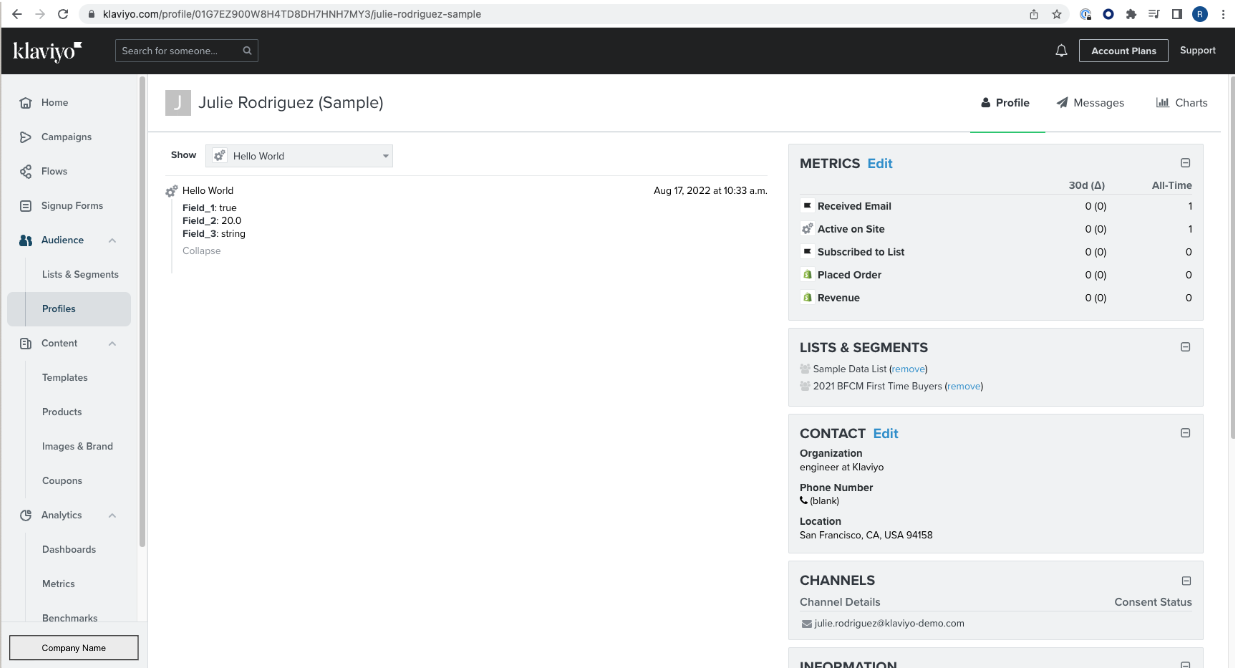

<a id='example_use_cases'></a>

## 4. Example use cases

Now that we have covered client-side events at a high level, it is time to explore specific ways that developers use this functionality.

<a id='common_uses_1'></a>

### 4.1 POST a *Viewed Product* event

#### Why set up a custom integration?

A core task for developers getting set up with Klaviyo is setting up an integration between what is happening on their website and their customer data living in Klaviyo. This is critically important to make sure that events like product orders are quickly and accurately reflected in your Klaviyo data. That type of event data is critical not only for sending follow-up communications, but also to secure future orders by better catering your messaging to your customers' tastes. 

If your site is hosted through a major ecommerce platform (e.g. Shopify, WooCommerce, etc.), then this task is already done for you through Klaviyo's pre-built integrations with these platforms. [Take a look at Klaviyo's full catalog of integrations.](https://help.klaviyo.com/hc/en-us/categories/115000032731-Ecommerce-Integrations)

If you have an online presence outside of those platforms, you may need to set up a custom integration. This is a common task for devs working to integrate larger brands into Klaviyo's ecosystem.

Since this is such a common task for developers, the developer experience team strives to make this as easy as we can. The most common way that devs choose to integrate with Klaviyo is through our JavaScript SDK. This is because of how JS can natively be embedded into websites' frontend.

#### Why are these examples in Python and not JavaScript?

<a id='faq_why_not_js'></a>

This guide will cover creating and uploading event data using `Python` and not `JavaScript`. This is to make sure that the concepts covered in this guide are accessible to as many developers as possible. 

Developers interested in running API requests in other languages should look through [Klaviyo's API documentation](https://developers.klaviyo.com/en/reference/api-overview). It has examples of how to make direct API calls on each of Klaviyo's endpoints in a number of frameworks including (`JavaScript`, `Node`, `Python`, `Java`, `PHP`, and `Shell` among others).

You can also find code snippets using the SDKs in other languages in our SDK documentation. For example, take a look at some common use cases with [Klaviyo's JS SDK.](https://developers.klaviyo.com/en/docs/javascript-api)

#### Let's see an example

The code below shows an example of how to define a *Viewed Product* event. In this case, Julie Rodriguez viewed a copy of Moby `dict`.

The dictionary describing the event, along with the company's public key, are passed to the `create_client_event` which uploads the event into the Klaviyo account and links it to Julie's customer profile.

In [7]:
# Note: Make sure uploaded events follow the style covered here: 
#       https://developers.klaviyo.com/en/docs/guide-to-integrating-a-platform-without-a-pre-built-klaviyo-integration

# TODO: replace with a customer email you want this event to apply to. Consider using the sample data tool 
#        to generate some test accounts: https://developers.klaviyo.com/en/docs/generate-sample-data
customer_email = 'julie.rodriguez@klaviyo-demo.com'

payload_as_dict = {'data':
    {
        "type": "event",
        "attributes":
            {
                "profile": {'email': customer_email},
                "metric": {
                    "name": 'Ordered Product'
                },
                "properties": {'Brand': 'Harcourt Classics',
                    'Categories': ['Fiction', 'Classics'],
                    'CompareAtPrice': 19.99,
                    'ImageURL': 'http://www.example.com/path/to/product/image.png',
                    'Price': 19.99,
                    'ProductID': 1112,
                    'ProductName': 'Moby Dict',
                    'URL': 'http://www.example.com/path/to/product'
                },
                "time": '2022-08-17T14:33:49+00:00'
            }
    }
}
      
# Note: on success, the SDK will return None and the HTTP will return a 202
klaviyo.Client.create_client_event(public_key, payload_as_dict)

#### View in Klaviyo's UI

As we can see, our *Ordered Product* event for Moby `dict` is now in Klaviyo. The event will now be reflected in analytics and trigger any appropriate flows.

The screen below was generated by going into the **Profiles** tab, then selecting the **Ordered Product** metric under the dropdown menu.

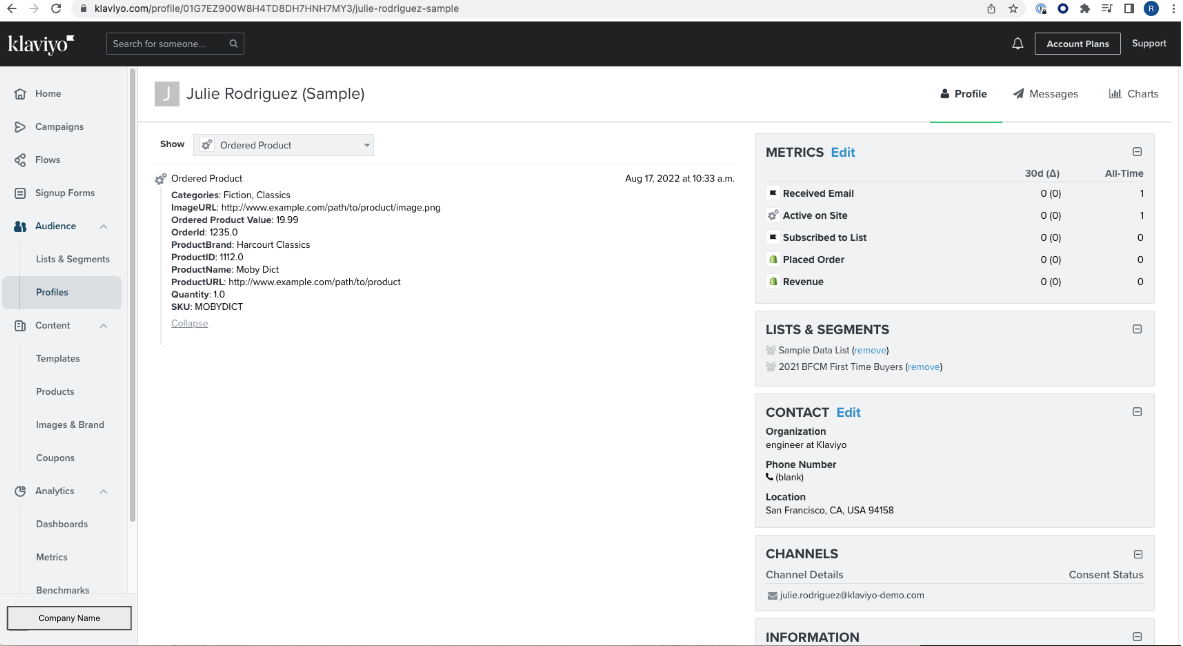

<a id='faq_dup_metric_names'></a>

#### Note: Metric names may appear duplicated if the account has multiple integrations.

Developers should be aware that if they upload data into an account from multiple sources, then some metric names may appear more than once in Klaviyo (shown below). This is because Klaviyo separates events based on their source. 

So, if an account uploads events both with a custom integration and through a pre-built integration, then the account will appear to have metric duplicates. The test account used in this tutorial has events uploaded through Shopify and Klaviyo's APIs. 

Events uploaded from different sources sometimes have different column names or data types. Klaviyo separates these metrics by default to help keep your data clean. Multiple integrations of the same type (e.g. multiple API integrations) will be grouped into the same bucket.

Klaviyo recommends developers keep metric names consistent regardless of the source (e.g. *Ordered Product* should not become *Ordered Product (From Website)*).

Klaviyo users of accounts with multiple integrations should be aware that their data is separated by source. Users who aren't aware of this nuance risk incomplete analytics and untriggered flows.

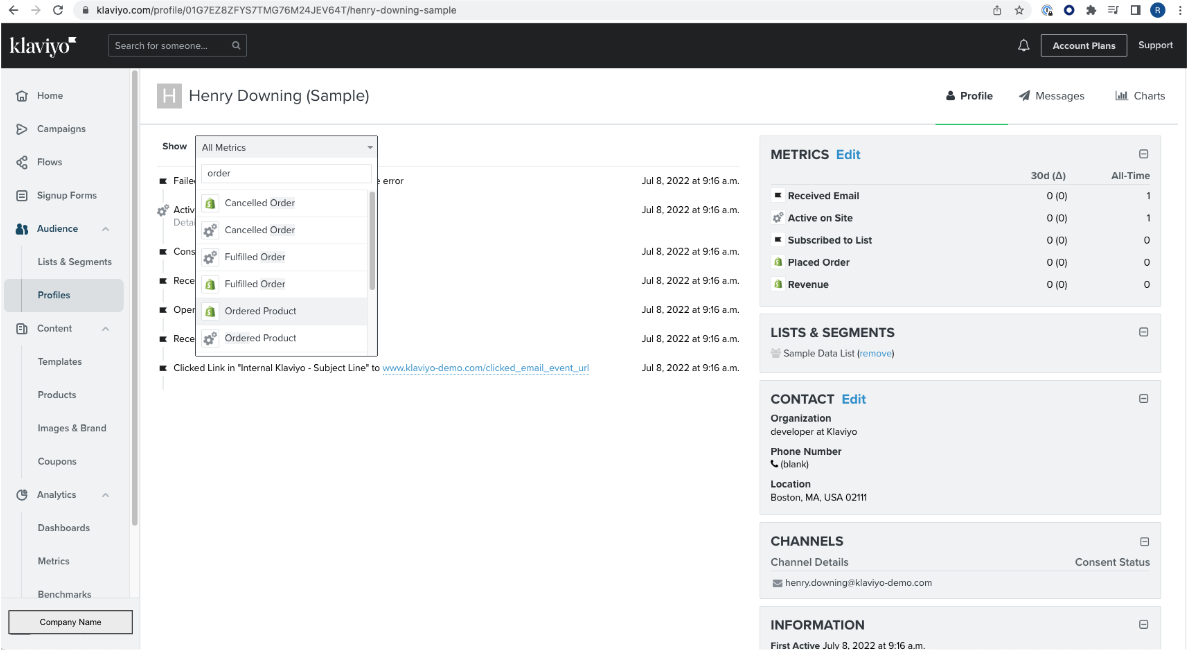

<a id='common_uses_2'></a>

### 4.2 Implementing customer review events

Let's say you are interested in tracking customer feedback on products or services that your business offers. Tracking feedback is a great way to better understand your customers' needs and monitor quality. As a customer data platform, Klaviyo is a natural place for this information to live.

In Klaviyo, you can store reviews, associate them with customer profiles, and implement flows reacting to real-time feedback.

To do this, let us break down this task into a few component parts:

1. Define the review event
2. Generate a few test reviews
3. Upload reviews to Klaviyo
4. Create a custom flow thanking reviewers

<a id='faq_schema'></a>

#### Klaviyo has a flexible, inferred typing model

Before diving into how to implement customer reviews, let's first cover how Klaviyo 

One of the most exciting things about working in Klaviyo's data ecosystem is how easy it is for developers to create custom profile attributes or events.

This is because Klaviyo's database uses flexible, inferred typing. 

This makes it much easier to POST custom events (as shown below) since developers do not need to provide a schema for new event types or attributes. Rather, Klaviyo handles all that on the back end by implicitly inferring column types from passed parameters.


<a id='faq_type_consistency'></a>

#### Schema-less events mean developers have more responsibility to keep types consistent

Developers can create new event types in just a few lines of code with implicit typing. The cost of this ease of development is more responsibility on devs to keep their typing choices consistent.

For example, you could upload a new event in the following (incorrect) format:

```python
# wrong format
"properties": {
    'stringColumn': integer,
    'integerColumn': string
}
```

Rather than:

```python
# right format
"properties": {
    'stringColumn': string,
    'intColumn': integer
}
```

Or, developers could mistakenly upload an event misspelling `stringColumn` as `STRINGCOLUMN`. These types of errors have the potential to cause problems downstream when pulling summary statistics or triggering flows. So, developers should keep data in a consistent format.

Ultimately though it is up to the developer to keep their company's data in a consistent format.

Klaviyo recommends that developers follow naming conventions [suggested in our custom integration guide](https://developers.klaviyo.com/en/docs/guide-to-integrating-a-platform-without-a-pre-built-klaviyo-integration) to keep these fields consistent.

#### Step 1: Define the review event

Here we can define a structure for the review event. While you do not need to provide a schema to Klaviyo's database, it can be helpful to sketch one out anyway to make sure that the event structure is clear and will be consistent moving forward.

A simple implementation of customer review events needs to track the following:
- Who wrote the review?
- When did the review get written?
- What item was reviewed?
- What rating did the customer give?
- What comments (if any) did the customer leave?

The structure of Klaviyo event data already asks for profile and time. The remaining three pieces of information (`review_text`, `review_rating_out_of_5`, and `catalog_item_id`) can be stored in the event's property field.

The structure of this payload should look something like:

```python
event_payload = {'data':
    {
        "type": "event",
        "attributes":
            {
                "profile": {
                    'email': string
                },
                "metric": {
                    "name": string
                },
                "properties": {
                    'review_text': string or NoneType,
                    'review_rating_out_of_5': int,
                    'catalog_item_id': string
                },
                "time": string (UTC-formatted datetime)
            }
    }
}
```

#### Step 2: Generate a few test reviews

Now that a structure for this event type has been decided, let us next generate a few fake reviews to test the functionality. 

These test reviews (in dictionary format) will form the body of the event data that is uploaded in Step 3.

In [8]:
# Example Review 1

# TODO: replace with a customer email you want this event to apply to. Consider using the sample data tool 
#        to generate some test accounts: https://developers.klaviyo.com/en/docs/generate-sample-data
customer_email = 'stacey.johnson@klaviyo-demo.com'


review_1_body = {
    'data': {
        "type": "event",
        "attributes": 
            {
                "profile": {
                    'email': customer_email
                },
                "metric": {
                    "name": 'Customer Review'
                },
                "properties": {
                    'review_text': 'I loved that chocolate chip cookie I ate!',
                    'review_rating_out_of_5': 5,
                    'catalog_item_id': '$custom:::$default:::SAMPLE-DATA-ITEM-1'
                },
                "time": '2022-08-18T08:10:22+00:00'
            }
    }
}

In [9]:
# Example Review 2

# TODO: replace with a customer email you want this event to apply to.
customer_email = 'julie.rodriguez@klaviyo-demo.com'

review_2_body = {
    'data': {
        "type": "event",
        "attributes": 
            {
                "profile": {
                    'email': customer_email
                },
                "metric": {
                    "name": 'Customer Review'
                },
                "properties": {
                    'review_text': 'My order never arrived 😡',
                    'review_rating_out_of_5': 1,
                    'catalog_item_id': '$custom:::$default:::SAMPLE-DATA-ITEM-1'
                },
                "time": '2022-08-18T08:10:22+00:00'
            }
    }
}

In [10]:
# Example Review 3

# TODO: replace with a customer email you want this event to apply to.
customer_email = 'julie.rodriguez@klaviyo-demo.com'

review_3_body = {
    'data': {
        "type": "event",
        "attributes": 
            {
                "profile": {
                    'email': customer_email
                },
                "metric": {
                    "name": 'Customer Review'
                },
                "properties": {
                    'review_text': None,
                    'review_rating_out_of_5': 4,
                    'catalog_item_id': '$custom:::$default:::SAMPLE-DATA-ITEM-12'
                },
                "time": '2022-08-18T08:10:22+00:00'
            }
    }
}

#### Step 3: Upload reviews to Klaviyo

Next, we can use the same `create_client_event` method used in example 4.1.

In [11]:
klaviyo.Client.create_client_event(public_key, review_1_body)
klaviyo.Client.create_client_event(public_key, review_2_body)
klaviyo.Client.create_client_event(public_key, review_3_body)

#### As we can see, these reviews are now in Klaviyo

There can be a delay of a few minutes for asynchronous, client-side API event requests to show up in Klaviyo. Once the wait is done, however, we can see the review events in Klaviyo.

Going into the **Profiles** tab, selecting Julie Rodriguez's profile, and choosing the **Customer Review** metric leads to the following screen. We can see below the two customer reviews associated with Julie's account.

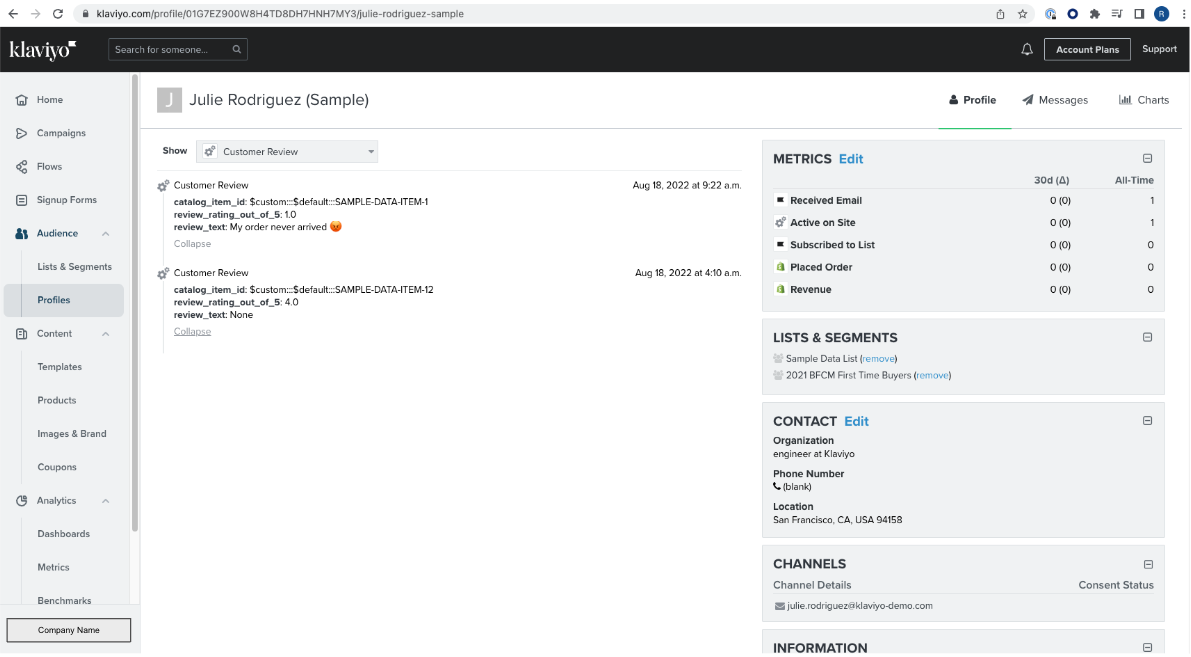

<a id='faq_using_event_in_flow'></a>

#### Step 4: Create a custom flow thanking reviewers

Now that the hard work is done, we can sit and consider what is possible now that customer review data is streaming into your Klaviyo account.

One idea is to set up a custom flow to respond to reviews in real-time. 

You can do this through Klaviyo's Flow feature:

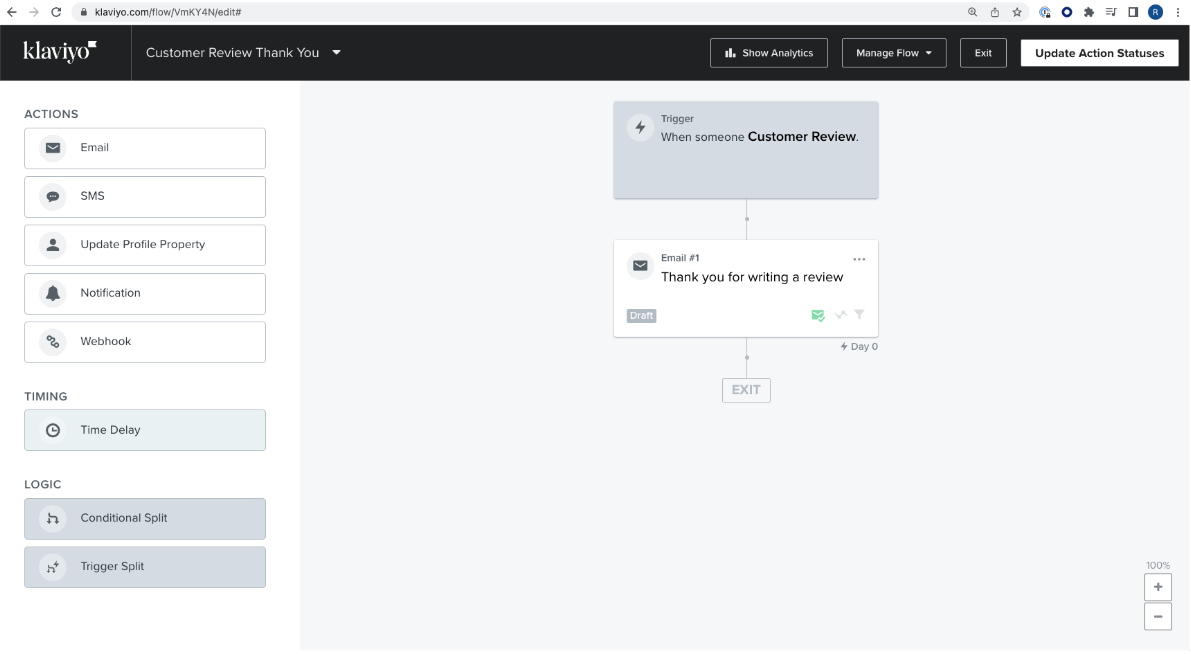

Taking this flow example to the next level, developers can use the custom metadata contained in these review events to target your messaging depending on customers' experience.

For example, a new version of this flow sends a different message depending on whether the review was positive or negative:

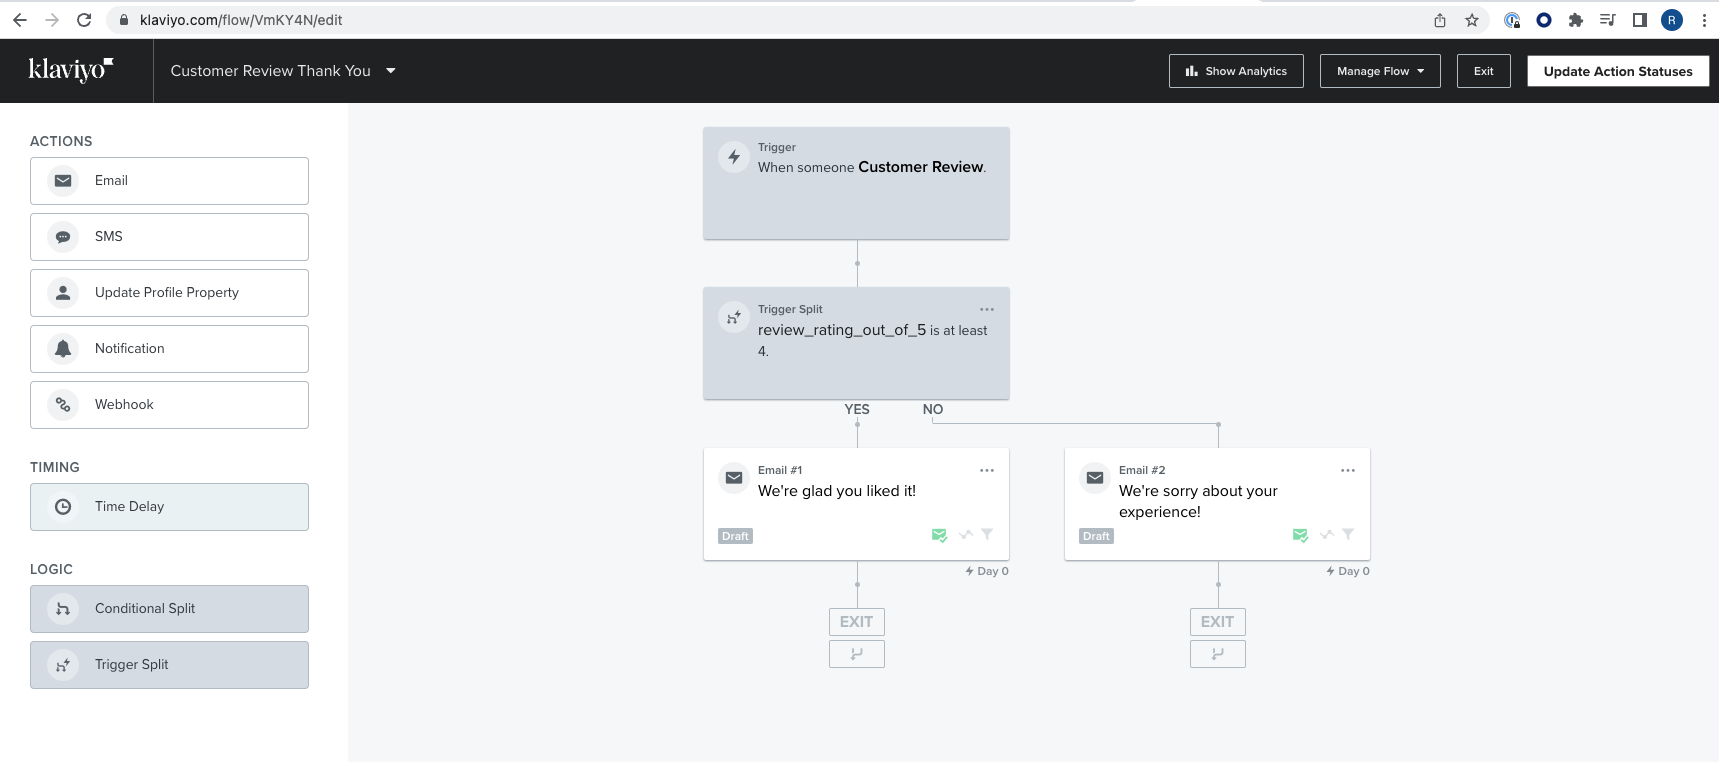

#### Customer reviews: let's review

This quick implementation of customer review events using client-side API endpoints underscores how Klaviyo's data structures and client-side APIs are configured to make developers' lives easy.

In a few minutes, you are able to create schema-less, custom events and use them to both collect useful customer data and drive marketing messaging.

<a id='common_uses_3'></a>

### 4.3 Add a new subscriber to a list

Another common way that developers use Klaviyo's client-side APIs is to collect email subscribers.

Let's look at how that can be accomplished below:

In [12]:
# TODO: replace these values if using this code snippet
email = 'stacey.johnson@klaviyo-demo.com'
list_id = 'LIST_ID'

body = {
    'data': {
        'type': 'subscription',
        'attributes': {
            'list_id': list_id,
            'email': email
        }
    }
}

klaviyo.Client.create_client_subscription(public_key, body)

As we can see, the profile has been added to the Newsletter list under the **Lists & Segments** tab.

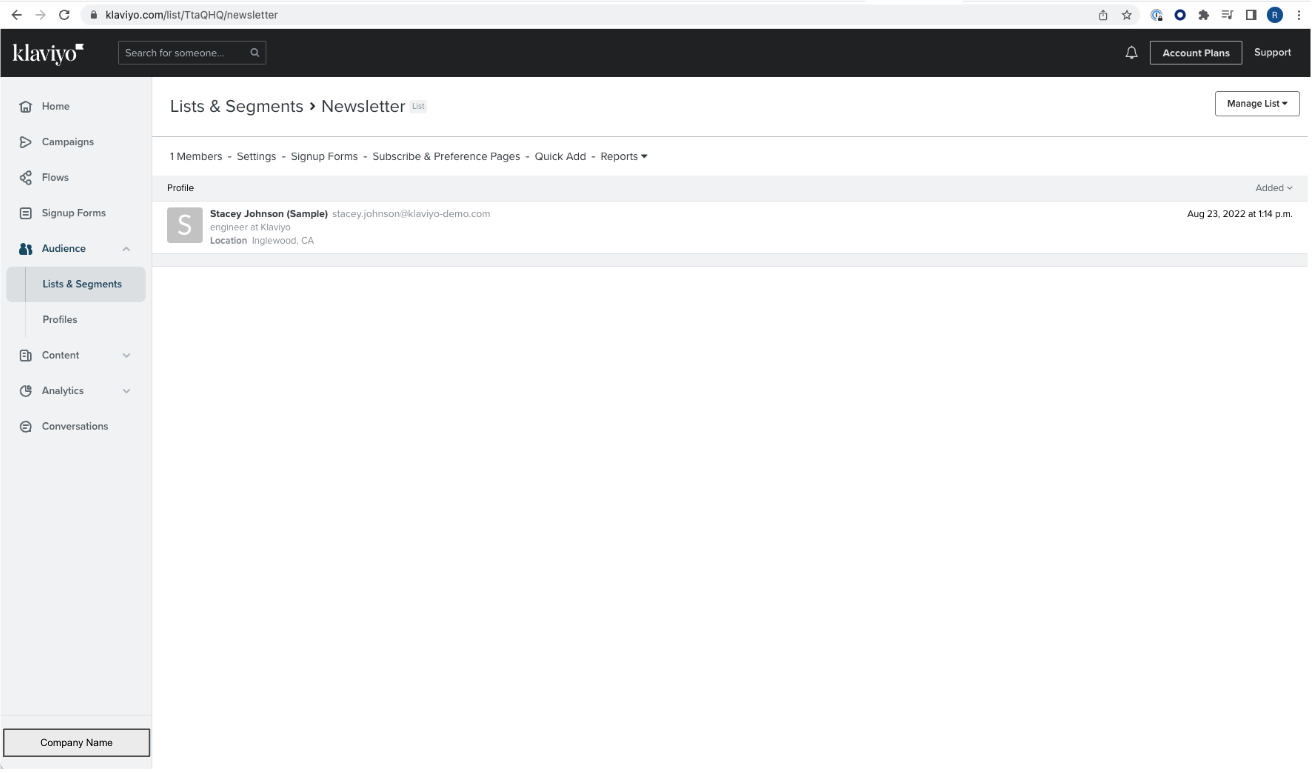

#### Common Question: Why am I running into issues with `create_client_subscription`?

A common issue that developers run into with the `create_client_subscription` functionality is that you may send a correctly formatted payload, and be surprised to see that the account in question has not been added to your desired list in Klaviyo.

This is often because of the difference between single opt-in and double opt-in lists.

By default, Klaviyo lists are double opt-in. This means that when you attempt to add an email address to a mailing list, users will get an email asking them to confirm that they want to receive this type of communication. This is a best practice that Klaviyo recommends to our customers to maintain high deliverability and positive customer impressions. [For more information about double opt-in see here.](https://help.klaviyo.com/hc/en-us/articles/115005251108-Understanding-the-double-opt-In-process)

To see if the list you are attempting to add a subscriber to is a single or double opt-in, go into your Klaviyo account under **Lists & Segments** then under **List Settings**. The list used in this illustrative example was changed to be single opt-in.

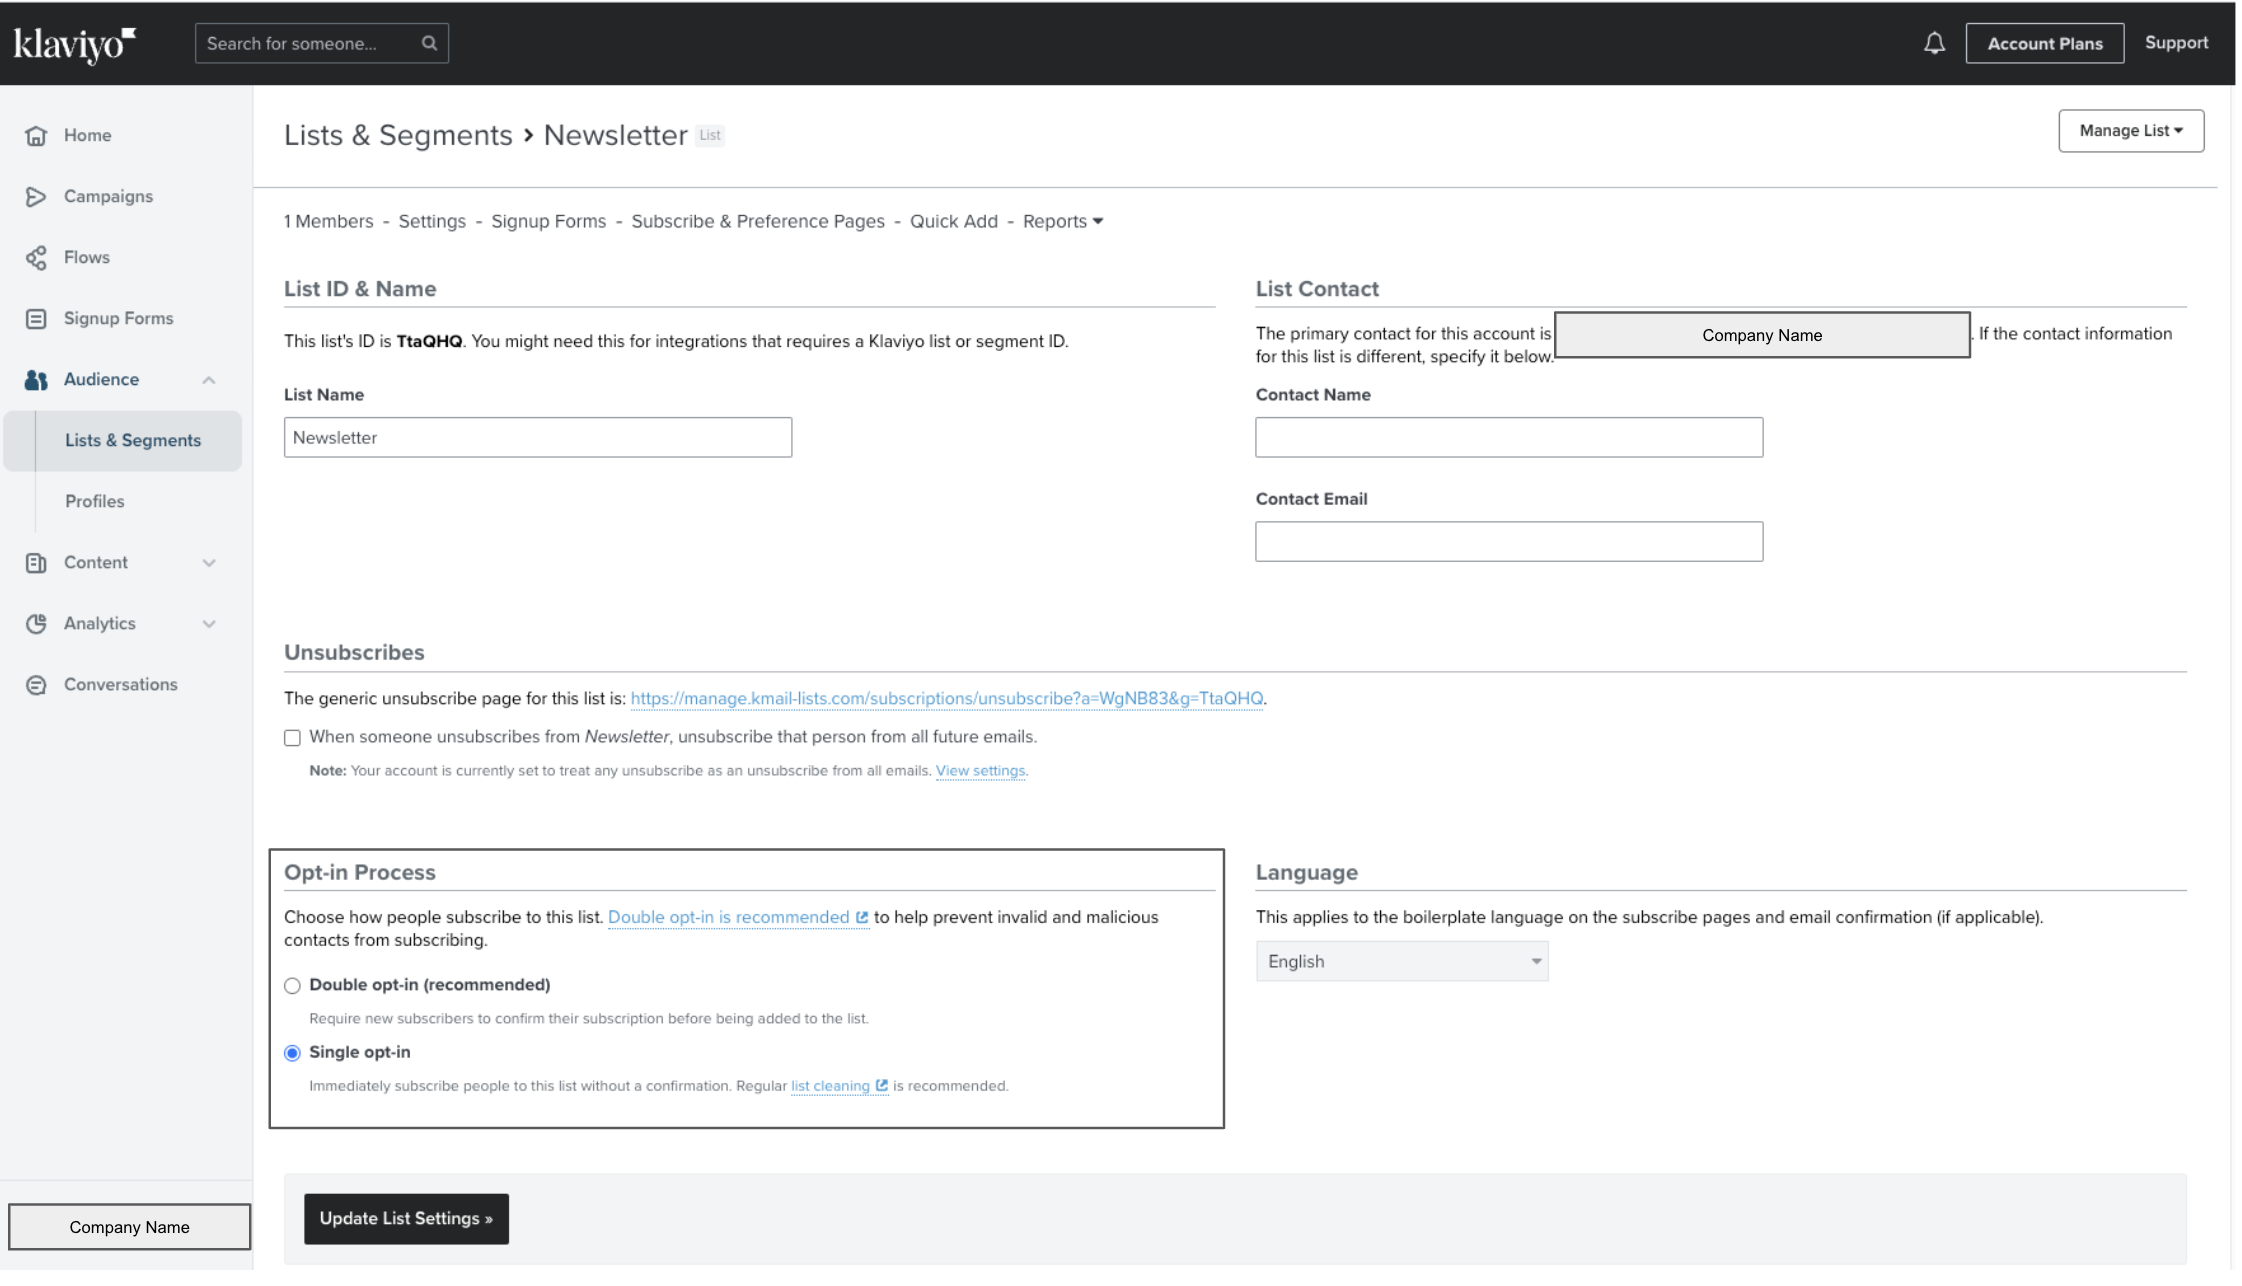

<a id='common_uses_4'></a>

### 4.4 Implementing a sign up page

Let's say that your business is considering creating a sign up page that lets customers create an account or edit an existing one. You need a way to be able to send updates quickly to your business' data in Klaviyo.

Developers can create this functionality using Klaviyo's client-side APIs, which are much easier to integrate into your site's frontend than server side requests with a private key.

Let's take a look at how this can be done.

#### Create a new profile 

Creating a new customer profile can be done through the SDK with the `create_client_profile` function. To create a new profile you will need to POST information on that customer account.

The profile payload should take the following form:

```python
# example profile schema
{
  "data": {
    "type": "profile",
    "attributes": {
      "email": "string",
      "phone_number": "string",
      "external_id": "string",
      "anonymous_id": "string",
      "first_name": "string",
      "last_name": "string",
      "organization": "string",
      "title": "string",
      "image": "string",
      "location": {
        "address1": "string",
        "address2": "string",
        "city": "string",
        "country": "string",
        "latitude": "string",
        "longitude": "string",
        "region": "string",
        "zip": "string",
        "timezone": "string"
      },
      "properties": {}
    },
    "meta": {
      "identifiers": {
        "id": "string",
        "external_id": "string",
        "email": "string",
        "phone_number": "string",
        "anonymous_id": "string",
        "_kx": "string"
      }
    }
  }
}
```

However, you do not need to provide all of the fields required. All that is necessary is some form of profile identifier, and a correctly formatted payload. For more information, please see [Klaviyo's API documentation.](https://developers.klaviyo.com/en/reference/create_client_profile)

So, if your sign up form does not ask for a customer's address feel free to leave those fields blank. They will be recorded as a NoneType in Klaviyo's dataset for the time being. You can always go back and update a profile to add or change its attributes.

In [13]:
### Here we define a simple profile payload with just name and email

body = {
  "data": {
    "type": "profile",
    "attributes": {
      "email": "NewTest@gmail.com",
      "first_name": "New",
      "last_name": "Test",
      "properties": {}
    },
    "meta": {
      "identifiers": {
        "email": "NewTest@gmail.com"
      }
    }
  }
}

klaviyo.Client.create_client_profile(public_key, body);

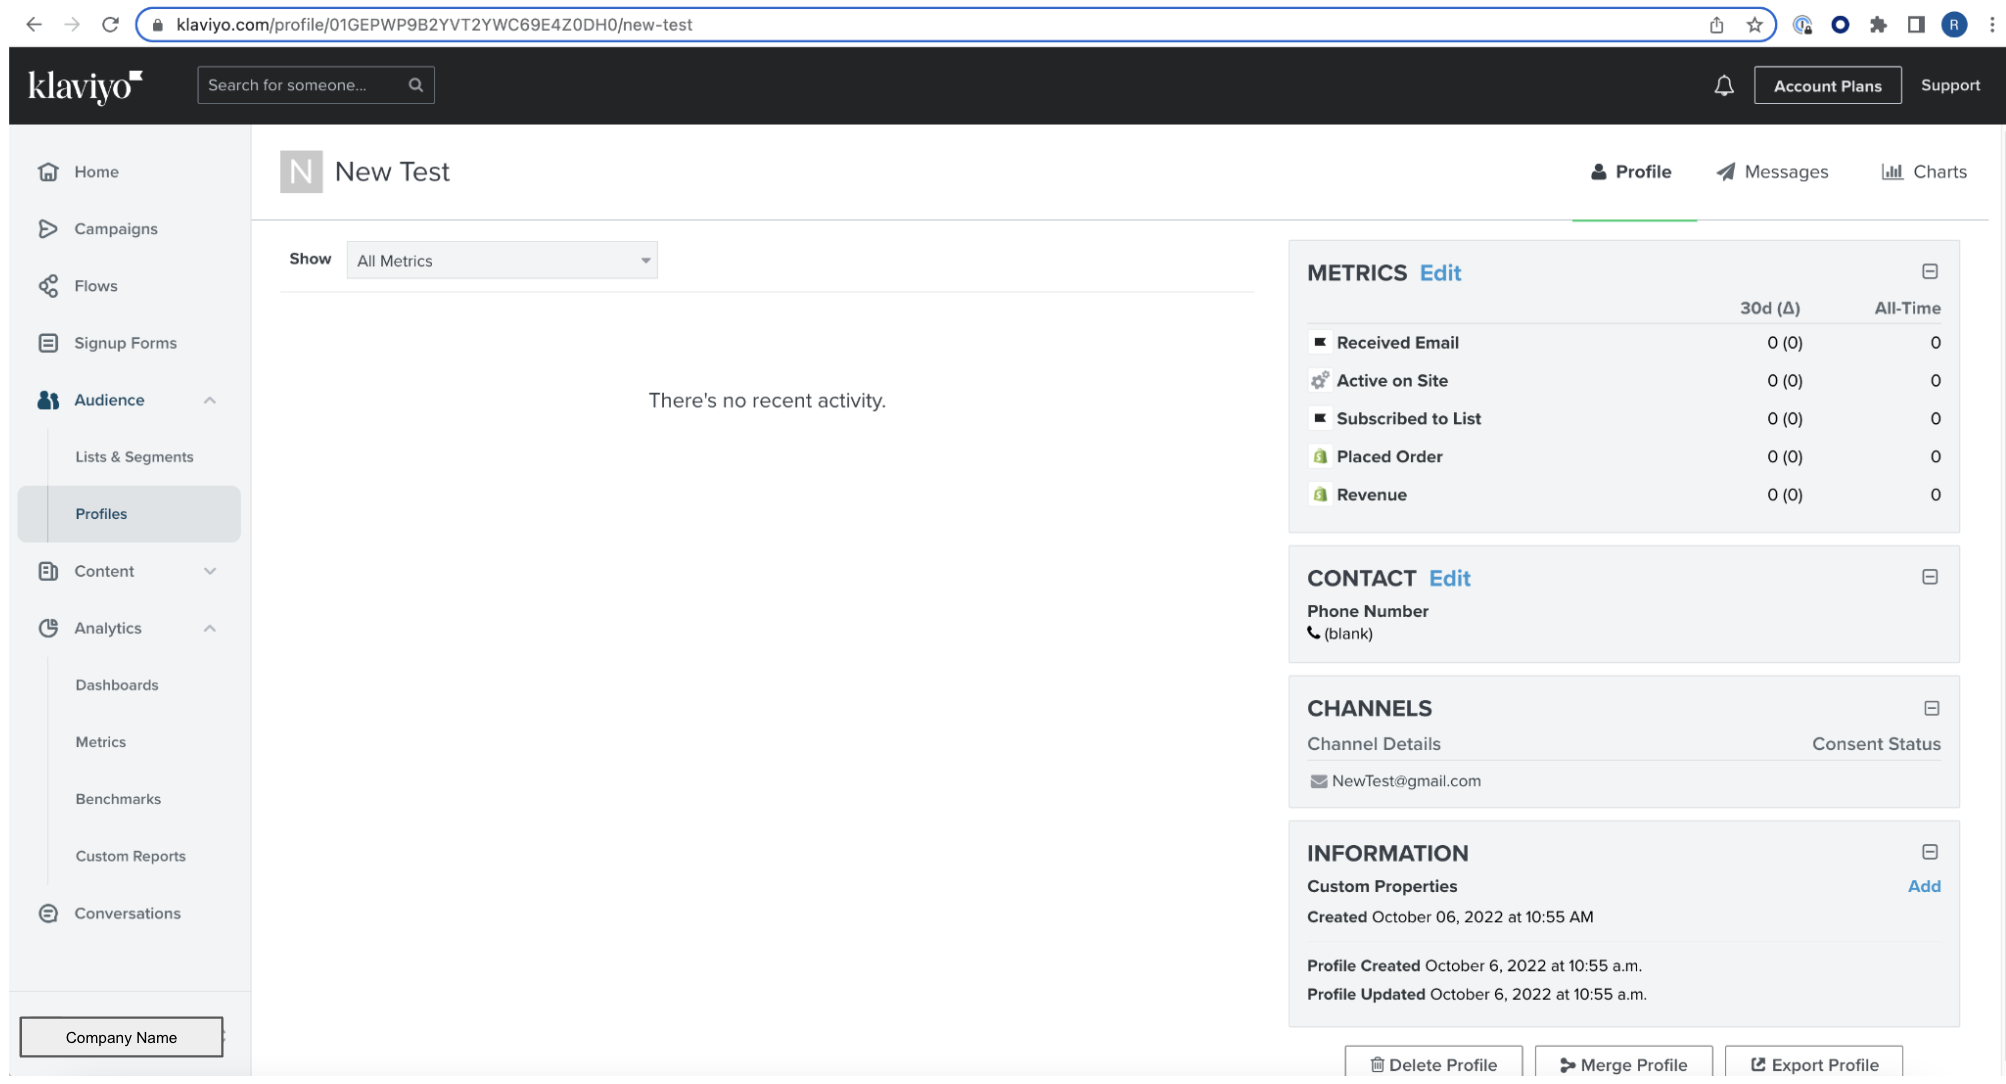

After we submitted the post request, our newest user: `New Test` now appears under account profiles. Since we did not provide a lot of information in the payload about `New Test`, many of the attribute fields are blank. Let's try updating the account.

#### Update an existing profile

Let's say that we want to do the following:
- Add a phone number
- Change name from `New` to `Newton`
- Add in Newton's favorite color

We can accomplish this using the same endpoint as the call above with a request body nearly identical to the one previously defined. The difference being that if you identify an account in the `meta` field that already exists in your account, the API will know to update the chosen account rather than create a new one.

Any values you specify in the `attributes` field will override the profile's prior value. For example, specifying `"first_name": "Newton"` means that the profile's first name will be changed to be `Newton`.

Quick notes:
- Profile identifiers (i.e. email, phone_number, and id) can be used to uniquely identify Klaviyo accounts. 
- Profile attributes (e.g. name, last purchase) are not necessarily unique and cannot be used to identify a profile
- Phone_number needs a country code (e.g. "+1[10_digit_phone_number]" would map to a valid US number)
- You only need to include fields you want to add or update, not all the attributes & identifiers previously defined for the profile.

In [14]:
body = {
  "data": {
    "type": "profile",
    "attributes": {
      "first_name": "Newton",
      "phone_number": '+13239169023',
      "properties": {
          'favorite_color': 'blue'
      }
    },
    "meta": {
      "identifiers": {
        "email": "NewTest@gmail.com"
      }
    }
  }
}

klaviyo.Client.create_client_profile(public_key, body)

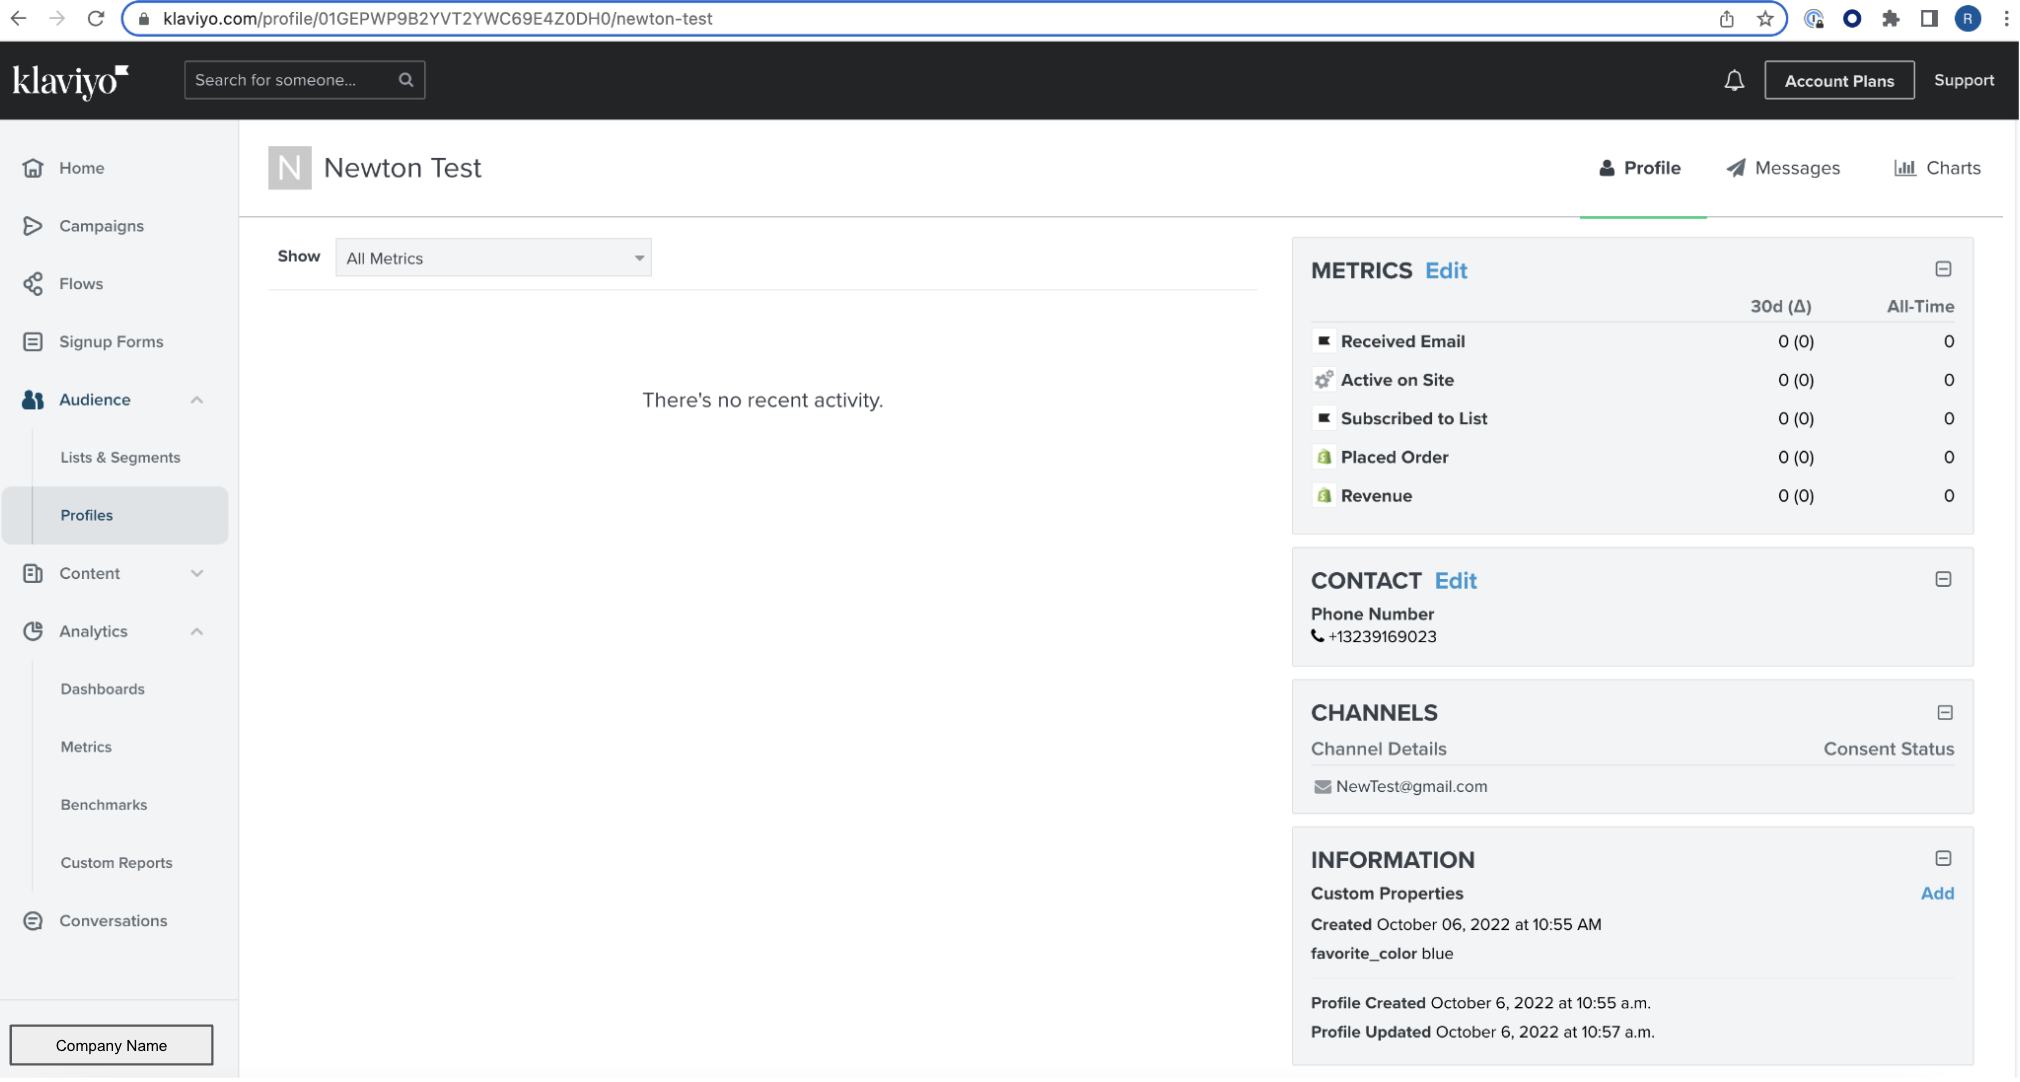

As we can see, `Newton Test` is looking a bit better. The name change is reflected and his phone number shows up as being `+1 323-916-9023` instead of being blank. The custom attribute `favorite_color` is reflected under **Custom Properties** in the **Information** section.

Businesses often learn about their customers in this iteratively way. So, Klaviyo's APIs are built to make the process of updating customer profiles as seamless as possible.

<a id='faq_post_event_new_profile'></a>

#### Aside: Developers can also create customer profiles by uploading an event

Below we upload an event via a client-side API request with the identifier set as: `{'email': 'NoCustomerHasThisEmail@gmail.com'`. The passed email address is correctly formatted, but it does not apply to any existing customer profiles currently in the account.

In this case, Klaviyo generates a new customer profile and associates this event with it. Let's set up a minimal working example and see the result within Klaviyo.

In [15]:
payload = {'data':
    {
        "type": "event",
        "attributes":
            {
                "profile": {
                    'email': 'NoCustomerHasThisEmail@gmail.com' # applies to no current profile
                },
                "metric": {
                    "name": 'Hello World'
                },
                "properties": {
                    'Quantity': 10
                }
            }
    }
}


klaviyo.Client.create_client_event(public_key, payload)

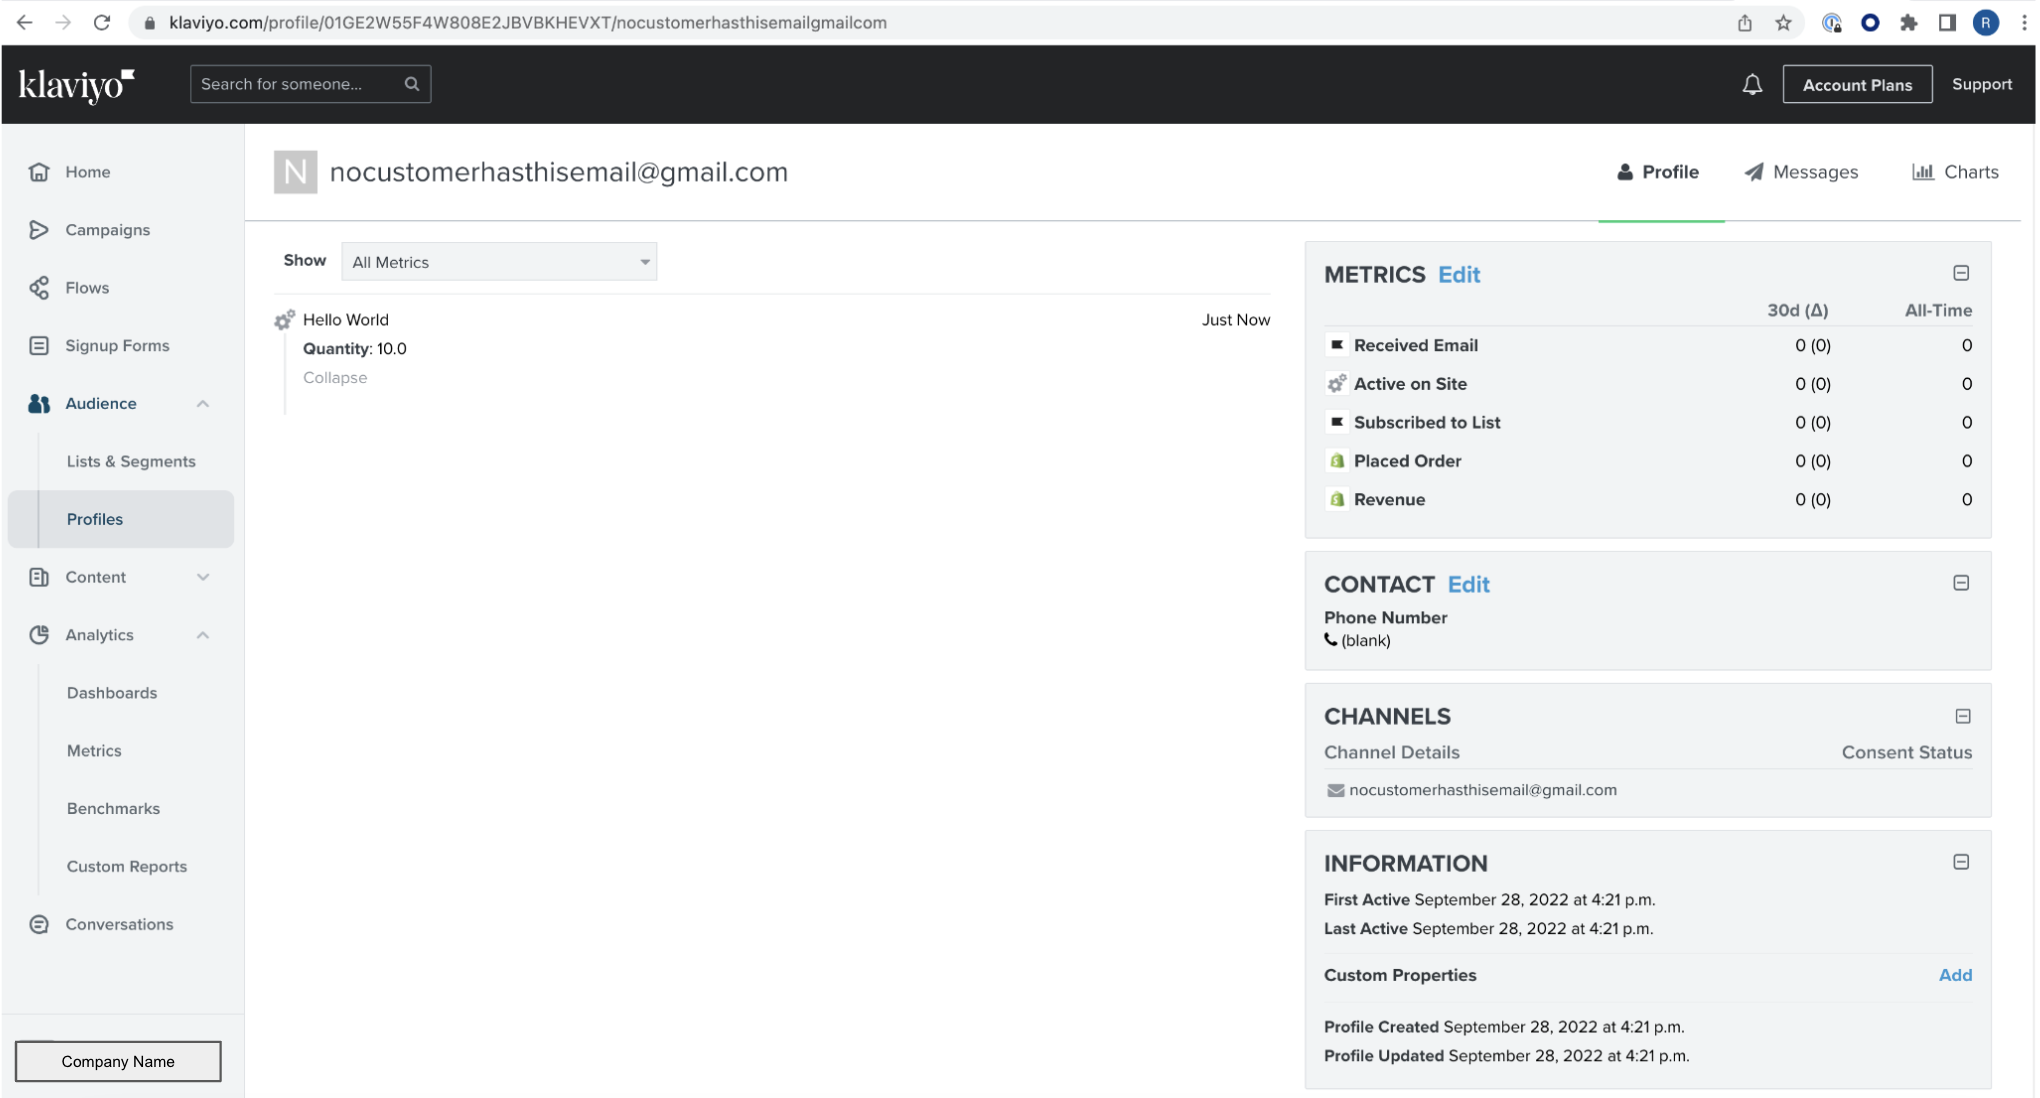

Notice that the customer profile that is generated via an event upload is sparse. We do not not know this customer's name, phone number, address, or many other core pieces of information. To fill these in, you would have to use the [Create Client Profile](https://developers.klaviyo.com/en/reference/create_client_profile) functionality to backfill in those missing attributes.

<a id='common_bugs'></a>

## 5. Common issues for developers

<a id='faq_response_codes'></a>

### What response codes are common?

| Response Code(s) | Success/Error | Description  |
| :------------ | :------------: | -------------: |
| `202` | Success (HTTP) |  The passed parameters were formatted correctly. This likely means that the request successfully went through, but for asynchronous API calls at the time the response is rendered the data has yet to be processed. |
| `NoneType` | Success (SDK) | The passed parameters were formatted correctly. This likely means that the request successfully went through, but for asynchronous API calls at the time the response is rendered the data has yet to be processed. |
| `400`, `403`, `404`  | Error | There is something wrong about the passed parameters, authentication, or endpoint URL that you are trying to query. The response should have more specific details. |
| `429` | Error | This means there was a rate limit issue. Klaviyo's APIs have rate limiting built in. If you have highly variable traffic, then consider adding retry logic and/or exponential backoff to your API calls. |
| `500` | Error | This is an error on Klaviyo's backend. Usually these are resolved with retry logic, but if it is persistent [please reach out to support.](https://help.klaviyo.com/hc/en-us/requests/new) |

### What response codes should I expect in different situations?

To make this response behavior more clear, let's look at a few examples of API calls and their responses in different common situations.

#### Passing an invalid payload

As a reminder, remember the SDK needs a dictionary body and HTTP requests need a `JSON string` body.

Below is an example of what happens when you switch that up. In this case, the SDK raises an error.

In [16]:
payload_as_dict = {'data':
    {
        "type": "event",
        "attributes":
            {
                "profile": {
                    'email': 'julie.rodriguez@klaviyo-demo.com'
                },
                "metric": {
                    "name": 'Example_Event_Test_without_key'
                },
                "properties": {
                    'Quantity': 10
                }
            }
    }
}

payload_as_json = json.dumps(payload_as_dict)

try:
    response = klaviyo.Client.create_client_event(public_key, payload_as_json)
    
except Exception as e:
    print(e)

Invalid type for variable 'event_create_query'. Required value type is EventCreateQuery and passed type was str at ['event_create_query']


<a id='faq_fake_phone_number'></a>

#### Invalid Profile Attribute: Passing a fake phone number

As mentioned before, the `phone_number` field is looking for a country code followed by a 10 digit phone number. There is also another requirement: the `phone_number` has to be real.

On the backend, Klaviyo's APIs make sure that inputted phone_numbers are valid, active phone lines.

This especially comes up when developers are testing functionality and try something like `0123456789` as a phone number, which is not an active line.

If you are testing this functionality, feel free to use the phone_numbers used in Klaviyo's documentation (e.g. `+13239169023`). The lines included there are managed by Klaviyo for this purpose.

In [17]:
#### Example error, trying to use a fake phone number

fake_number = '+11234567890'

body = {
  "data": {
    "type": "profile",
    "attributes": {
      "phone_number": fake_number
    },
    "meta": {
      "identifiers": {
        "email": "NewTest@gmail.com"
      }
    }
  }
}

try:
    klaviyo.Client.create_client_profile(public_key, body)
    
except Exception as e:
    print(e)

Status Code: 400
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Wed, 19 Oct 2022 21:52:33 GMT', 'Content-Type': 'application/vnd.api+json; charset=utf-8', 'Content-Length': '223', 'Connection': 'keep-alive', 'CF-Ray': '75ccbdd2ae177faa-IAD', 'Access-Control-Allow-Origin': '*', 'Allow': 'GET, POST, HEAD, OPTIONS', 'Vary': 'Cookie, Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'CID': 'WgNB83', 'X-Robots-Tag': 'noindex, nofollow', 'Server': 'cloudflare'})
HTTP response body: {"errors":[{"id":"3fc42620-6cd6-4be8-8c26-9aa459353b06","status":400,"code":"invalid","title":"Invalid input.","detail":"Invalid or unsupported phone number","source":{"pointer":"/data/attributes/phone_number"},"meta":{}}]}



As you can see, trying to upload a fake phone number leads to a `Invalid or unsupported phone number` error response.

#### Invalid Profile Attribute: Passing a malformed email

Klaviyo developers often have to pass email addresses as profile identifiers. These email strings can sometimes be mis-formatted -- often because of typos on the part of end users.

In these cases, Klaviyo's APIs throw an error. Let's take a look:

In [18]:
bad_email_address = 'Not Correctly Formatted @gmail.com'

body = {
  "data": {
    "type": "profile",
    "attributes": {
      "email": bad_email_address
    },
    "meta": {
      "identifiers": {
        "email": bad_email_address
      }
    }
  }
}

try:
    klaviyo.Client.create_client_profile(public_key, body)
    
except Exception as e:
    print(e)

Status Code: 400
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Wed, 19 Oct 2022 21:52:34 GMT', 'Content-Type': 'application/vnd.api+json; charset=utf-8', 'Content-Length': '202', 'Connection': 'keep-alive', 'CF-Ray': '75ccbdd4a9357faa-IAD', 'Access-Control-Allow-Origin': '*', 'Allow': 'GET, POST, HEAD, OPTIONS', 'Vary': 'Cookie, Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'CID': 'WgNB83', 'X-Robots-Tag': 'noindex, nofollow', 'Server': 'cloudflare'})
HTTP response body: {"errors":[{"id":"e58f96a4-8597-44e2-b5a8-42ed557d3db2","status":400,"code":"invalid","title":"Invalid input.","detail":"Invalid email address","source":{"pointer":"/data/attributes/email"},"meta":{}}]}



Here, the error let's you know that the email address is not valid with the response `"detail":"Invalid email address"`

#### SDK Successful Call Example

Now that we've seen a few examples of what happens when things go wrong, let's take a look at response behavior on successful calls.

On successful API calls, the client-side SDK will return a `NoneType`

In [19]:
good_payload_as_dict = {'data':
    {
        "type": "event",
        "attributes":
            {
                "profile": {
                    'email': 'julie.rodriguez@klaviyo-demo.com'
                },
                "metric": {
                    "name": 'Example_Event_Test_without_key'
                },
                "properties": {
                    'Quantity': 10
                }
            }
    }
}

response = klaviyo.Client.create_client_event(public_key, good_payload_as_dict)

print(response, type(response))

None <class 'NoneType'>


#### HTTP Successful Call Example

Similar to the unsuccessful direct HTTP request, the response to this successful call is a 202. This means that the payload is formatted correctly.

The difference between the successful and unsuccessful call is that this event actually appears in Klaviyo after successfully being uploaded and processed.

In [20]:
headers = {
    'Content-Type': "application/json",
    'revision': "2022-10-17"
}

good_payload_as_json = json.dumps(good_payload_as_dict)

url = "https://a.klaviyo.com/client/events/"

response = requests.request("POST", 
                            url, 
                            data=good_payload_as_json, 
                            headers=headers, 
                            params={"company_id": public_key})

print(response)
print(response.reason)
print(response.text)

<Response [202]>
Accepted



### Where can I get more information?

Developers who want more information about what type of response codes they should expect can look through [Klaviyo's custom integration FAQ](https://developers.klaviyo.com/en/docs/custom-integration-faqs#i-received-a-1-response-from-the-track-api-but-my-event-isnt-appearing-in-klaviyo).

For persistent issues, consider looking through [Klaviyo's developer resources](https://developers.klaviyo.com/en) or [reaching out to Klaviyo's support team](https://help.klaviyo.com/hc/en-us/requests/new).

<a id='conclusion'></a>

## 6. Wrapping up

Whew. We've covered a lot of information in this walkthrough. We've gone from Hello World to setting up custom review events and using them to trigger custom flows.

Hopefully at the end of this tutorial you've learned something about how Klaviyo's data is structured and how using client-side requests on your site can help maximize the value you generate with your Klaviyo account.

Developers with any more questions after reading this guide, should consider looking through the other guided code walkthroughs that are part of Klaviyo's documentation or reaching out to our talented Solution Architects:

- [API Documentation](https://developers.klaviyo.com/en/reference/api-overview)
- [Klaviyo SDKs](https://developers.klaviyo.com/en/docs/sdk-overview)
- [API Guides Repository](https://github.com/klaviyo-labs/klaviyo-api-guides-public)
- [Klaviyo Developer Community Q&A](https://community.klaviyo.com/groups/developer-group-64)
- [Klaviyo Help Center](https://help.klaviyo.com/hc/en-us)
- [Support Requests](https://help.klaviyo.com/hc/en-us/requests/new)